In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

from pathlib import Path
#from torch import cdist
import os


In [2]:
from catboost import CatBoostClassifier
from hmmlearn import hmm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.neighbors import NearestNeighbors
import math
# from statsmodels.tsa.arima.model import ARIMA

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
ROOT_DIR = Path().cwd()
while not ROOT_DIR.joinpath("data").exists():
    ROOT_DIR = ROOT_DIR.parent
os.chdir(ROOT_DIR)

In [5]:
from processors import processor_factory
from data.DatasetManager import DatasetManager

bpic2011_f1
bpic2011_f2
bpic2011_f3
bpic2011_f4


In [6]:
case_id_col = 'Case ID'
timestamp_col = 'time:timestamp'
target_col = "Activity"
dataset_name = 'sepsis_cases_1'

In [7]:
df = pd.read_csv('data/processed_benchmark_event_logs/BPIC11_f1.csv', sep=';')

In [8]:
df = pd.read_csv('data/processed_benchmark_event_logs/sepsis_cases_1.csv', sep=';')

In [9]:
dataset_manager = DatasetManager(dataset_name)

In [10]:
df[dataset_manager.timestamp_col] = pd.to_datetime(df[dataset_manager.timestamp_col])

In [11]:
df.sort_values([dataset_manager.case_id_col, dataset_manager.timestamp_col], inplace=True)

In [12]:
df[dataset_manager.case_id_col].nunique()

782

In [13]:
df

,Diagnose,DiagnosticArtAstrup,DiagnosticBlood,DiagnosticECG,DiagnosticIC,DiagnosticLacticAcid,DiagnosticLiquor,DiagnosticOther,DiagnosticSputum,DiagnosticUrinaryCulture,...,time:timestamp,timesincemidnight,month,weekday,hour,timesincelastevent,timesincecasestart,event_nr,open_cases,label
0,A,True,True,True,True,True,False,False,False,True,...,2014-10-22 09:15:41,555,10,2,9,0.000000,0.000000,1,81,regular
1,A,True,True,True,True,True,False,False,False,True,...,2014-10-22 09:27:00,567,10,2,9,0.000000,11.316667,2,81,regular
2,A,True,True,True,True,True,False,False,False,True,...,2014-10-22 09:27:00,567,10,2,9,0.000000,11.316667,3,81,regular
3,A,True,True,True,True,True,False,False,False,True,...,2014-10-22 09:27:00,567,10,2,9,11.316667,11.316667,4,81,regular
4,A,True,True,True,True,True,False,False,False,True,...,2014-10-22 09:33:37,573,10,2,9,6.616667,17.933333,5,81,regular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13115,C,True,True,True,True,True,False,False,False,True,...,2014-11-16 12:05:00,725,11,6,12,365.000000,9319.683333,20,75,regular
13116,C,True,True,True,True,True,False,False,False,True,...,2014-11-17 06:00:00,360,11,0,6,0.000000,10394.683333,21,77,regular
13117,C,True,True,True,True,True,False,False,False,True,...,2014-11-17 06:00:00,360,11,0,6,1075.000000,10394.683333,22,77,regular
13118,C,True,True,True,True,True,False,False,False,True,...,2014-11-18 06:00:00,360,11,1,6,1440.000000,11834.683333,23,78,regular


In [14]:
earliest_timestamps = df.groupby(dataset_manager.case_id_col)[dataset_manager.timestamp_col].min()


In [15]:
earliest_timestamps

Case ID
A                2014-10-22 09:15:41
AAA              2014-11-19 02:16:21
ABA              2014-10-12 09:22:24
AC               2014-09-24 13:39:13
AD               2013-12-19 08:04:38
                         ...        
ZV               2014-11-27 13:37:18
ZW               2014-10-03 04:07:59
ZX               2013-12-31 19:55:37
ZZ               2014-11-12 15:34:30
missing_caseid   2014-11-10 00:45:19
Name: time:timestamp, Length: 782, dtype: datetime64[ns]

In [16]:
max_case_num = df[dataset_manager.case_id_col].nunique()

In [17]:
def get_first_n_cases(df, n):
    earliest_timestamps = df.groupby(case_id_col)[timestamp_col].min()
    sorted_cases = earliest_timestamps.sort_values().index[:n]
    return df[df[case_id_col].isin(sorted_cases)]

In [18]:
filtered_df = get_first_n_cases(df, max_case_num)

In [19]:
# for col in [dataset_manager.activity_col]:
#         counts = filtered_df[col].value_counts()
#         mask = filtered_df[col].isin(counts[counts >= 500].index)
#         filtered_df.loc[~mask, col] = "other"

In [47]:
import seaborn as sns

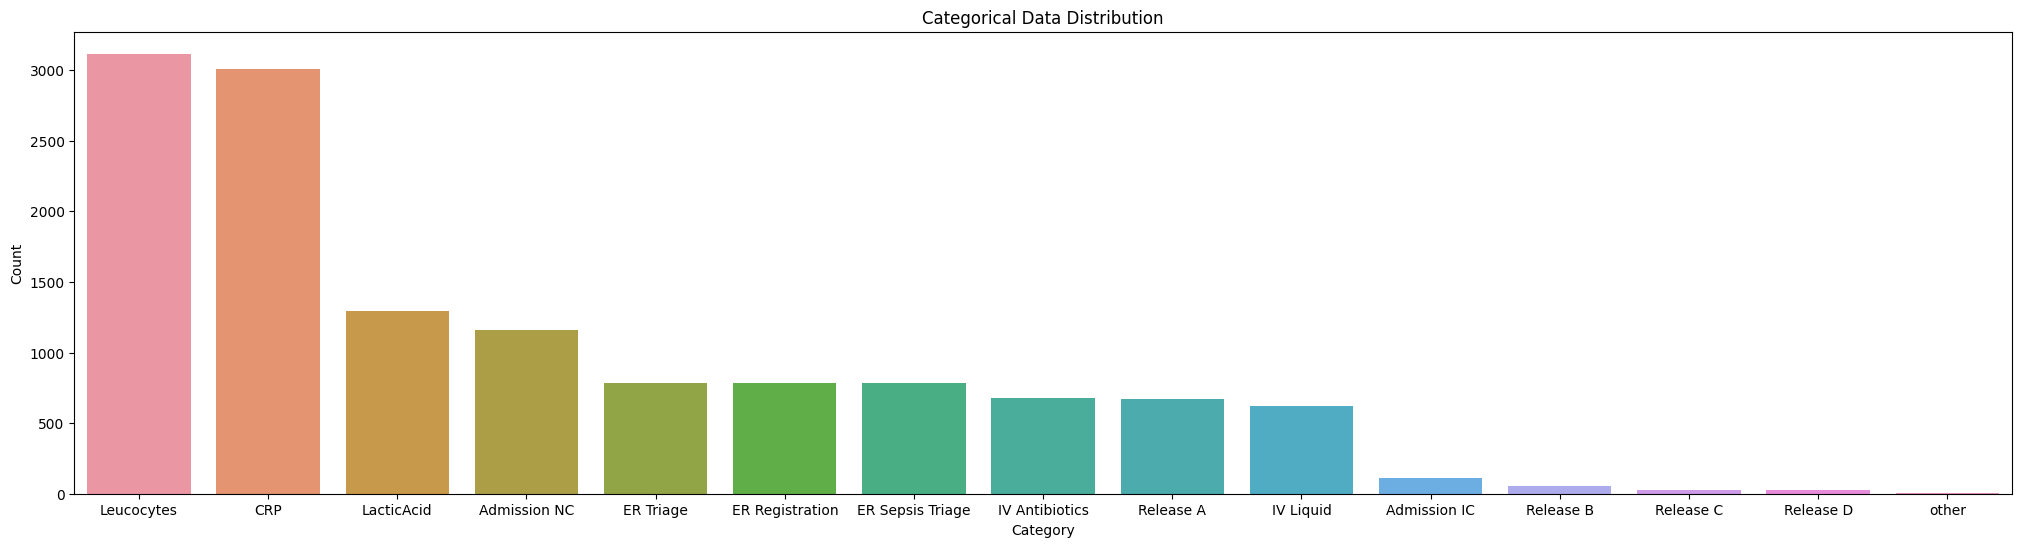

In [51]:
category_counts=filtered_df[dataset_manager.activity_col].value_counts()
# Count the occurrences of each category


# Plot using seaborn
plt.figure(figsize=(25, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Categorical Data Distribution')
plt.show()

In [21]:
results = []
method = 'Catboost'
config = 'no_encoding_no_bucketing'
# config = 'no_encoding_bucketing'
# config = 'encoding_no_bucketing'
# config = 'encoding_bucketing'

In [22]:
# from data.dataset_confs import dataset_configs

# config = dataset_configs['CSL_5L']
use_encoding = False
use_bucketing = False
num_nearest_neighbors = 100
distance_metric = 'euclidean'

# processor = CSL_5LProcessor("5L", use_encoding, use_bucketing, num_nearest_neighbors, distance_metric)
processor = processor_factory.get_processor(dataset_name, use_encoding, use_bucketing, num_nearest_neighbors, distance_metric)

In [23]:
import time

In [24]:
filtered_df = filtered_df.sort_values([case_id_col, 'event_nr'], ascending=True, kind='mergesort')
filtered_df[dataset_manager.target_col] = filtered_df.groupby(case_id_col)[dataset_manager.activity_col].shift(-1)

In [25]:
min_prefix_length = 1
max_prefix_length = filtered_df['event_nr'].max()

In [ ]:
# import importlib
# #import DatasetManager
# import data.DatasetManager

# # Replace 'your_module_name' with the actual name of the file/module you want to reimport
# importlib.reload(data.DatasetManager)

In [26]:
start_test_prefix_generation = time.time()
print("Generating prefix data...")
dt_prefixes = dataset_manager.generate_prefix_data(filtered_df, min_prefix_length, max_prefix_length)
test_prefix_generation_time = time.time() - start_test_prefix_generation

Generating prefix data...
Activity


In [27]:
dt_prefixes["Target"].isnull().sum()

782

In [28]:
import data.EncoderFactory as EncoderFactory

In [29]:
encoder = EncoderFactory.get_encoder(method='agg', case_id_col=case_id_col, static_cat_cols=None, static_num_cols=dataset_manager.static_num_cols, dynamic_cat_cols=dataset_manager.activity_col,
                dynamic_num_cols=[], fillna=True, max_events=None, activity_col=dataset_manager.activity_col, resource_col=None, timestamp_col=timestamp_col,
                scale_model=None)

In [30]:
dt_transformed = encoder.transform(dt_prefixes)
dt_transformed.columns

Index(['Admission IC', 'Admission NC', 'CRP', 'ER Registration',
       'ER Sepsis Triage', 'ER Triage', 'IV Antibiotics', 'IV Liquid',
       'LacticAcid', 'Leucocytes', 'Release A', 'Release B', 'Release C',
       'Release D', 'other'],
      dtype='object')

In [31]:
dt_transformed.reset_index(drop=False, inplace=False)[case_id_col]

0                       A
1                     AAA
2                  AAA_10
3                   AAA_2
4                   AAA_3
               ...       
13115    missing_caseid_5
13116    missing_caseid_6
13117    missing_caseid_7
13118    missing_caseid_8
13119    missing_caseid_9
Name: Case ID, Length: 13120, dtype: object

In [32]:
def return_last_row(group):
    max_event_row = group.loc[group['event_nr'].idxmax()]
    return max_event_row

In [33]:
subset = dt_prefixes[[case_id_col, timestamp_col, dataset_manager.activity_col, 'Target', 'event_nr'] + dataset_manager.static_num_cols+dataset_manager.static_cat_cols]
subset = subset.groupby(case_id_col).apply(return_last_row).reset_index(drop=True)

In [34]:
merged_df = pd.merge(subset, dt_transformed, on=[dataset_manager.case_id_col])
merged_df

,Case ID,time:timestamp,Activity,Target,event_nr,Age,Diagnose,DiagnosticArtAstrup,DiagnosticBlood,DiagnosticECG,...,ER Triage,IV Antibiotics,IV Liquid,LacticAcid,Leucocytes,Release A,Release B,Release C,Release D,other
0,A,2014-10-22 09:15:41,ER Registration,Leucocytes,1,85.0,A,True,True,True,...,0,0,0,0,0,0,0,0,0,0
1,AAA,2014-11-19 02:16:21,ER Registration,ER Triage,1,60.0,C,False,True,True,...,0,0,0,0,0,0,0,0,0,0
2,AAA_10,2014-11-22 10:30:00,Release A,NaN,10,60.0,C,False,True,True,...,1,1,1,1,1,1,0,0,0,0
3,AAA_2,2014-11-19 02:18:49,ER Triage,ER Sepsis Triage,2,60.0,C,False,True,True,...,1,0,0,0,0,0,0,0,0,0
4,AAA_3,2014-11-19 02:19:09,ER Sepsis Triage,IV Liquid,3,60.0,C,False,True,True,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13115,missing_caseid_5,2014-11-10 01:03:14,IV Liquid,Leucocytes,5,90.0,C,True,True,True,...,1,1,1,0,0,0,0,0,0,0
13116,missing_caseid_6,2014-11-10 01:23:00,Leucocytes,CRP,6,90.0,C,True,True,True,...,1,1,1,0,1,0,0,0,0,0
13117,missing_caseid_7,2014-11-10 01:23:00,CRP,LacticAcid,7,90.0,C,True,True,True,...,1,1,1,0,1,0,0,0,0,0
13118,missing_caseid_8,2014-11-10 01:23:00,LacticAcid,Admission NC,8,90.0,C,True,True,True,...,1,1,1,1,1,0,0,0,0,0


In [35]:
# Step 1: Identify object columns
object_columns = merged_df.select_dtypes(include=['object']).columns

# Step 2: Check if object columns contain boolean values
for col in object_columns:
    if merged_df[col].isin(['True', 'False', 'TRUE', 'FALSE', 'true', 'false']).all():
        merged_df[col] = merged_df[col].str.lower().map({'true': True, 'false': False})

        # Step 3: Transform boolean object columns to boolean data type
        merged_df[col] = merged_df[col].astype('boolean')

# Display the transformed DataFrame
merged_df.dtypes


Case ID                              object
time:timestamp               datetime64[ns]
Activity                             object
Target                               object
event_nr                              int64
Age                                 float64
Diagnose                             object
DiagnosticArtAstrup                  object
DiagnosticBlood                      object
DiagnosticECG                        object
DiagnosticIC                         object
DiagnosticLacticAcid                 object
DiagnosticLiquor                     object
DiagnosticOther                      object
DiagnosticSputum                     object
DiagnosticUrinaryCulture             object
DiagnosticUrinarySediment            object
DiagnosticXthorax                    object
DisfuncOrg                           object
Hypotensie                           object
Hypoxie                              object
InfectionSuspected                   object
Infusion                        

In [36]:
merged_df[dataset_manager.activity_col].nunique()

15

In [ ]:
# merged_df.to_csv('data/sepsis_encoded.csv', sep=';', index=False)

In [37]:
merged_df

,Case ID,time:timestamp,Activity,Target,event_nr,Age,Diagnose,DiagnosticArtAstrup,DiagnosticBlood,DiagnosticECG,...,ER Triage,IV Antibiotics,IV Liquid,LacticAcid,Leucocytes,Release A,Release B,Release C,Release D,other
0,A,2014-10-22 09:15:41,ER Registration,Leucocytes,1,85.0,A,True,True,True,...,0,0,0,0,0,0,0,0,0,0
1,AAA,2014-11-19 02:16:21,ER Registration,ER Triage,1,60.0,C,False,True,True,...,0,0,0,0,0,0,0,0,0,0
2,AAA_10,2014-11-22 10:30:00,Release A,NaN,10,60.0,C,False,True,True,...,1,1,1,1,1,1,0,0,0,0
3,AAA_2,2014-11-19 02:18:49,ER Triage,ER Sepsis Triage,2,60.0,C,False,True,True,...,1,0,0,0,0,0,0,0,0,0
4,AAA_3,2014-11-19 02:19:09,ER Sepsis Triage,IV Liquid,3,60.0,C,False,True,True,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13115,missing_caseid_5,2014-11-10 01:03:14,IV Liquid,Leucocytes,5,90.0,C,True,True,True,...,1,1,1,0,0,0,0,0,0,0
13116,missing_caseid_6,2014-11-10 01:23:00,Leucocytes,CRP,6,90.0,C,True,True,True,...,1,1,1,0,1,0,0,0,0,0
13117,missing_caseid_7,2014-11-10 01:23:00,CRP,LacticAcid,7,90.0,C,True,True,True,...,1,1,1,0,1,0,0,0,0,0
13118,missing_caseid_8,2014-11-10 01:23:00,LacticAcid,Admission NC,8,90.0,C,True,True,True,...,1,1,1,1,1,0,0,0,0,0


In [41]:
# Define the values to experiment with
results = []
trainingtimes = []
num_nearest_neighbors_values = [100]
distance_metrics = ['euclidean']

# Loop through the values and create processors
for num_nearest_neighbors in num_nearest_neighbors_values:
    for distance_metric in distance_metrics:
        print(f"Experimenting with num_nearest_neighbors={num_nearest_neighbors} and distance_metric={distance_metric}")
        
        # Create the processor with the current values
        processor = processor_factory.get_processor(dataset_name, use_encoding=False, use_bucketing=False, num_nearest_neighbors=num_nearest_neighbors, distance_metric=distance_metric)
        
    

        data = merged_df.sort_values([dataset_manager.case_id_col, dataset_manager.timestamp_col], ascending=True, kind='mergesort')
        # data['Target'] = data.groupby(case_id_col)[target_col].shift(-1)
        # data['Target_orig'] = data.groupby(case_id_col)['Titer (g/L) original'].shift(-1)
        data['Target'] = data.groupby(dataset_manager.case_id_col)['Target'].ffill().bfill()
        # data['Target_orig'] = data.groupby(case_id_col)['Target_orig'].ffill()

        historic, current = processor.split_data_strict(data, train_ratio=0.5)
        historic.sort_values([dataset_manager.timestamp_col], ascending=True, kind='mergesort', inplace=True)
        current.sort_values([dataset_manager.timestamp_col], ascending=True, kind='mergesort', inplace=True)
        current = current.head(200)

        # if config == 'no_encoding_bucketing' or config == 'encoding_bucketing':
        #     features_used = processor.static_num_cols + processor.dynamic_num_cols + processor.static_cat_cols + processor.dynamic_cat_cols + ['Cluster']
        # else:
        #     features_used = processor.static_num_cols + processor.dynamic_num_cols + processor.static_cat_cols + processor.dynamic_cat_cols

        # Exclude specific columns from historic
        features_used = historic.columns.difference([dataset_manager.target_col, dataset_manager.timestamp_col, dataset_manager.case_id_col])
        # n_neighbors = 200
        # # Initialize the NearestNeighbors model
        # nn_model = NearestNeighbors(n_neighbors=n_neighbors, metric="cosine")
        # # Fit the model on the historic data
        # nn_model.fit(historic[features_used])

        batch_size = 100

        initial_start_time = time.time()

        num_model, cat_model = processor.train_nn_model_bpic_encoding(historic[features_used])
        # nn_model = NearestNeighbors(n_neighbors=num_nearest_neighbors, metric=distance_metric)
        # nn_model.fit(historic.drop(columns=['Target', dataset_manager.timestamp_col, dataset_manager.case_id_col, dataset_manager.activity_col]))

        initial_end_time = time.time()

        initial_training_time = initial_end_time - initial_start_time
        print("Initial Model Training time: ", initial_training_time, " seconds")

        for start in range(0, len(current), batch_size):
            end = start + batch_size
            batch = current.iloc[start:end]
            # Find the n nearest neighbors for the selected row
            # distances, indices = nn_model.kneighbors(batch.drop(columns=[dataset_manager.target_col, dataset_manager.timestamp_col, dataset_manager.case_id_col, dataset_manager.activity_col]).to_numpy())
            distances, indices = processor.find_nearest_neighbors_encoding(cat_model, num_model, batch[features_used])
            nearest_neighbors = pd.concat([historic.iloc[indices[i]] for i in range(len(batch))])
            # nearest_neighbors = historic.iloc[indices.flatten()]

            # print(distances.shape)
            # print(indices.shape)

            # print(cat_model)
            # print(num_model)
            # print(features_used)
            # print(batch[features_used].shape)
            print(nearest_neighbors.shape)

            target = nearest_neighbors[dataset_manager.target_col].values
            target_test = batch[dataset_manager.target_col]

            if target_test is None:
                continue
            

            start_time = time.time()
            if method == 'Catboost':
                
                # categorical_features_indices = [nearest_neighbors.columns.get_loc(col) for col in processor.static_cat_cols+processor.dynamic_cat_cols]
                # Create the CatBoostRegressor model
                # model = CatBoostClassifier(iterations=100, loss_function='MultiClass', verbose=0, cat_features=processor.static_cat_cols + processor.dynamic_cat_cols) # , max_ctr_complexity=1
                model = CatBoostClassifier(iterations=1000, loss_function='MultiClass', verbose=0, cat_features=[dataset_manager.activity_col]+dataset_manager.static_cat_cols)
                print('Now training')
                model.fit(nearest_neighbors[features_used], target, cat_features=[dataset_manager.activity_col]+dataset_manager.static_cat_cols)

            if method == 'HMM':
                # Create an instance of the HMM model
                model = hmm.GaussianHMM(n_components=7)  # Specify the number of hidden states
                model.fit(nearest_neighbors[features_used])

            end_time = time.time()

            training_time = (end_time - start_time) / 60
            print("Training time: ", training_time, " minutes")
            trainingtimes.append(training_time)

            # Make predictions on the testing data
            print('Now predicting')
            preds = model.predict(batch[features_used])

            # Check if array has null values
            has_null = pd.Series(preds.flatten(), index=batch.index).isna().any()

            if has_null:
                print("Preds has null values")


            # true_conc_glu = row['Target_orig']
            # preds_scaled = scalers[target_col].inverse_transform(preds.reshape(-1, 1))

            batch.loc[:, 'predicted_value'] = pd.Series(preds.flatten(), index=batch.index)
            is_null = batch['predicted_value'].isna().any()
            if is_null:
                print("Batch has null values")

            results.append(batch)

            # Add the current row with its prediction to the historic data
            # row_with_prediction[target_col] = preds_scaled[0][0]
            historic = pd.concat([historic, batch], ignore_index=True)
            historic.sort_values([case_id_col, timestamp_col], ascending=True, kind='mergesort', inplace=True)
            historic.drop(columns=['predicted_value'], inplace=True)
            # nn_model =processor.train_nn_model_bpic(historic)  # Refit the model with the updated historic data
            # nn_model.fit(historic.drop(columns=['Target', timestamp_col, case_id_col, dataset_manager.activity_col]))
            num_model, cat_model = processor.train_nn_model_bpic_encoding(historic[features_used])

        results_df = pd.concat(results)

        # Calculate metrics
        true_values = results_df[target_col]
        predicted_values = results_df['predicted_value']

        accuracy = np.mean(true_values == predicted_values)
        # MAE_t = mean_absolute_error(true_values, predicted_values)
        # MSE_t = mean_squared_error(true_values, predicted_values)
        # RMSE_t = math.sqrt(MSE_t)
        # r2_t = r2_score(true_values, predicted_values)
        # mape_t = mean_absolute_percentage_error(true_values, predicted_values)

        # Save results to a CSV file
        # results_df.to_csv('predictions_with_row_data.csv', index=False)

        # Print metrics
        print(f"Accuracy: {accuracy}")
        # print(f"MAE: {MAE_t}")
        # print(f"MSE: {MSE_t}")
        # print(f"RMSE: {RMSE_t}")
        # print(f"R2: {r2_t}")
        # print(f"MAPE: {mape_t}")

        output_dir = Path(f"results/{dataset_name}")
        output_dir.mkdir(parents=True, exist_ok=True)
        # dataset_name.mkdir(parents=True, exist_ok=True)
        results_df.to_csv(f'{output_dir}/BPIC2011_{method}_{config}_{num_nearest_neighbors}_{distance_metric}.csv', index=False)
        print('***********************************')


Experimenting with num_nearest_neighbors=100 and distance_metric=euclidean
Index(['Admission IC', 'Admission NC', 'Age', 'CRP', 'ER Registration',
       'ER Sepsis Triage', 'ER Triage', 'IV Antibiotics', 'IV Liquid',
       'LacticAcid', 'Leucocytes', 'Release A', 'Release B', 'Release C',
       'Release D', 'event_nr', 'other'],
      dtype='object')
Index(['Activity', 'Diagnose', 'DiagnosticArtAstrup', 'DiagnosticBlood',
       'DiagnosticECG', 'DiagnosticIC', 'DiagnosticLacticAcid',
       'DiagnosticLiquor', 'DiagnosticOther', 'DiagnosticSputum',
       'DiagnosticUrinaryCulture', 'DiagnosticUrinarySediment',
       'DiagnosticXthorax', 'DisfuncOrg', 'Hypotensie', 'Hypoxie',
       'InfectionSuspected', 'Infusion', 'Oligurie', 'SIRSCritHeartRate',
       'SIRSCritLeucos', 'SIRSCritTachypnea', 'SIRSCritTemperature',
       'SIRSCriteria2OrMore'],
      dtype='object')
***********************************
['CRP', 'LacticAcid', 'Leucocytes', 'hour', 'weekday', 'month', 'timesincemidn

In [57]:
len(target)

10000

In [59]:
####### Baseline Version without JITL ########

# Define the values to experiment with

print(f"Experimenting with baseline version")

# Create the processor with the current values
processor = processor_factory.get_processor(dataset_name, use_encoding=False, use_bucketing=False, num_nearest_neighbors=num_nearest_neighbors, distance_metric=distance_metric)



data = merged_df.sort_values([dataset_manager.timestamp_col], ascending=True, kind='mergesort')
data['Target'] = data.groupby(case_id_col)['Target'].ffill().bfill()

historic, current = processor.split_data_strict(data, train_ratio=0.5)
historic.sort_values([dataset_manager.timestamp_col], ascending=True, kind='mergesort', inplace=True)
current.sort_values([dataset_manager.timestamp_col], ascending=True, kind='mergesort', inplace=True)


features_used = historic.columns.difference([dataset_manager.target_col, dataset_manager.timestamp_col, dataset_manager.case_id_col])
target = historic['Target'].values

start_time = time.time()
if method == 'Catboost':
        model = CatBoostClassifier(iterations=1000, loss_function='MultiClass', verbose=0, cat_features=[dataset_manager.activity_col]+dataset_manager.static_cat_cols)
        print('Now training')
        model.fit(historic[features_used], target, cat_features=[dataset_manager.activity_col]+dataset_manager.static_cat_cols)

if method == 'HMM':
    # Create an instance of the HMM model
    model = hmm.GaussianHMM(n_components=7)  # Specify the number of hidden states
    model.fit(historic[features_used])

end_time = time.time()
training_time = (end_time - start_time) / 60
print("Training time: ", training_time, " minutes")
# trainingtimes.append(training_time)
batch_size = 100

for start in range(0, len(current), batch_size):
    end = start + batch_size
    batch = current.iloc[start:end]

    target = historic['Target'].values
    target_test = batch['Target']

    if target_test is None:
        continue

    print('Now predicting')
    # Make predictions on the testing data
    preds = model.predict(batch[features_used])

    # Check if array has null values
    has_null = pd.Series(preds.flatten(), index=batch.index).isna().any()
    if has_null:
        print("Preds has null values")

    batch.loc[:, 'predicted_value'] = pd.Series(preds.flatten(), index=batch.index)
    is_null = batch['predicted_value'].isna().any()
    if is_null:
        print("Batch has null values")

    results.append(batch)


results_df = pd.concat(results)

# Calculate metrics
true_values = results_df[target_col]
predicted_values = results_df['predicted_value']

accuracy = np.mean(true_values == predicted_values)

# Save results to a CSV file
# results_df.to_csv('predictions_with_row_data.csv', index=False)

# Print metrics
print(f"Accuracy: {accuracy}")
# print(f"MAE: {MAE_t}")

results_df.to_csv(f'results/{dataset_name}/baseline_sepsis_{method}_{config}.csv', index=False)
print('***********************************')


Experimenting with baseline version
Now training
Training time:  10.873105315367381  minutes
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now predicting
Now pre

In [ ]:
results_df

In [ ]:
results_df = pd.DataFrame(results)

# Calculate metrics
true_values = results_df['true_value']
predicted_values = results_df['predicted_value']

MAE_t = mean_absolute_error(true_values, predicted_values)
MSE_t = mean_squared_error(true_values, predicted_values)
RMSE_t = math.sqrt(MSE_t)
r2_t = r2_score(true_values, predicted_values)
mape_t = mean_absolute_percentage_error(true_values, predicted_values)

# Save results to a CSV file
# results_df.to_csv('predictions_with_row_data.csv', index=False)

# Print metrics
print(f"MAE: {MAE_t}")
print(f"MSE: {MSE_t}")
print(f"RMSE: {RMSE_t}")
print(f"R2: {r2_t}")
print(f"MAPE: {mape_t}")

In [ ]:
results_df.to_csv(f'results/CSL312_{method}_{config}_200_results.csv', index=False)

In [ ]:
import importlib
import sys
import time

In [ ]:
min_prefix_length = 1
max_prefix_length = df_normalized[work_day_col].max()

In [ ]:
# Remove both EncoderFactory and AggregateTransformer from sys.modules
modules_to_remove = ['EncoderFactory', 'transformers.AggregateTransformer', 'DatasetManager', "dataset_confs"]
for module in modules_to_remove:
    if module in sys.modules:
        del sys.modules[module]

# Re-import the modules
import EncoderFactory
import transformers.AggregateTransformer
import DatasetManager
from DatasetManager import DatasetManager

# Reload the modules
importlib.reload(transformers.AggregateTransformer)
importlib.reload(EncoderFactory)
# importlib.reload(DatasetManager)

In [ ]:
dataset_manager = DatasetManager("CSL312")

In [ ]:
start_test_prefix_generation = time.time()
dt_prefixes = dataset_manager.generate_prefix_data(df_normalized, min_prefix_length, max_prefix_length)
test_prefix_generation_time = time.time() - start_test_prefix_generation

In [ ]:
dt_prefixes[target_col].isnull().sum()

In [ ]:
dt_prefixes

In [ ]:
encoder = EncoderFactory.get_encoder(method='agg', case_id_col=case_id_col, static_cat_cols=None, static_num_cols=None, dynamic_cat_cols=['Cluster'],
                dynamic_num_cols=features, target_cols=[target_col,'Titer (g/L) original'], work_day_col=work_day_col, fillna=True, max_events=None, activity_col=None, resource_col=None, timestamp_col=timestamp_col,
                scale_model=None)

In [ ]:
dt_transformed = encoder.transform(dt_prefixes)
dt_transformed.columns

In [ ]:
dt_transformed = dt_transformed.reset_index(drop=False, inplace=False)
dt_transformed[work_day_col] = dt_transformed[case_id_col].str.split('_').str[2]
dt_transformed[work_day_col] = dt_transformed[work_day_col].fillna(0)
dt_transformed[case_id_col] = dt_transformed[case_id_col].str.split('_').str[0] + '_' + dt_transformed[case_id_col].str.split('_').str[1]


In [ ]:

dt_transformed


In [ ]:
features_new = [col for col in dt_transformed.columns if col not in ["Cluster", "'Titer (g/L) original'", case_id_col, target_col, work_day_col]]

In [ ]:
results = []
method = 'Catboost'
# config = 'no_encoding_no_bucketing'
# config = 'no_encoding_bucketing'
config = 'encoding_no_bucketing'
# config = 'encoding_bucketing'

data = dt_prefixes.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort')
# data['Target'] = data.groupby(case_id_col)[target_col].shift(-1)
# data['Target_orig'] = data.groupby(case_id_col)['Titer (g/L) original'].shift(-1)
# data['Target'] = data.groupby(case_id_col)['Target'].ffill()
# data['Target_orig'] = data.groupby(case_id_col)['Target_orig'].ffill()

historic, current = split_data(data, train_ratio=0.5, split="temporal sim")
historic.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)
current.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)

if config == 'no_encoding_bucketing' or config == 'encoding_bucketing':
    features_used = features + ['Cluster']
else:
    features_used = features

# Initialize the NearestNeighbors model
nn_model = NearestNeighbors(n_neighbors=200)
# Fit the model on the historic data
nn_model.fit(historic[features_used])

for index, row in current.iterrows():
    # Find the n nearest neighbors for the selected row
    distances, indices = nn_model.kneighbors([row[features_used]])
    nearest_neighbors = historic.iloc[indices[0]]

    target = nearest_neighbors['Target'].values
    target_test = row['Target']

    if target_test is None:
        continue
    

    if method == 'Catboost':
        # Create the CatBoostRegressor model
        model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='MAE', verbose=0)
        model.fit(nearest_neighbors[features_used], target)

    if method == 'HMM':
        # Create an instance of the HMM model
        model = hmm.GaussianHMM(n_components=7)  # Specify the number of hidden states
        model.fit(df_without_last[features+['Cluster']])

    # Make predictions on the testing data
    preds = model.predict(row[features_used])

    true_conc_glu = row['Target_orig']
    preds_scaled = scalers[target_col].inverse_transform(preds.reshape(-1, 1))
    
    key = row[case_id_col] + '_' + str(row[work_day_col])
    results.append({
        'key': key,
        'row_data': row.to_dict(),
        'true_value': true_conc_glu,
        'predicted_value': preds_scaled[0][0]
    })

    # Add the current row with its prediction to the historic data
    row_with_prediction = row.copy()
    # row_with_prediction[target_col] = preds_scaled[0][0]
    historic = pd.concat([historic, pd.DataFrame([row_with_prediction])], ignore_index=True)
    historic.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)
    nn_model.fit(historic[features_used])  # Refit the model with the updated historic data


In [ ]:
results_df = pd.DataFrame(results)

# Calculate metrics
true_values = results_df['true_value']
predicted_values = results_df['predicted_value']

MAE_t = mean_absolute_error(true_values, predicted_values)
MSE_t = mean_squared_error(true_values, predicted_values)
RMSE_t = math.sqrt(MSE_t)
r2_t = r2_score(true_values, predicted_values)
mape_t = mean_absolute_percentage_error(true_values, predicted_values)

# Save results to a CSV file
# results_df.to_csv('predictions_with_row_data.csv', index=False)

# Print metrics
print(f"MAE: {MAE_t}")
print(f"MSE: {MSE_t}")
print(f"RMSE: {RMSE_t}")
print(f"R2: {r2_t}")
print(f"MAPE: {mape_t}")

In [ ]:
results_df.to_csv(f'results/CSL312_{method}_{config}_results.csv', index=False)

In [ ]:
results_df = pd.DataFrame(results)

# Calculate metrics
true_values = results_df['true_value']
predicted_values = results_df['predicted_value']

MAE_t = mean_absolute_error(true_values, predicted_values)
MSE_t = mean_squared_error(true_values, predicted_values)
RMSE_t = math.sqrt(MSE_t)
r2_t = r2_score(true_values, predicted_values)
mape_t = mean_absolute_percentage_error(true_values, predicted_values)

# Save results to a CSV file
# results_df.to_csv('predictions_with_row_data.csv', index=False)

# Print metrics
print(f"MAE: {MAE_t}")
print(f"MSE: {MSE_t}")
print(f"RMSE: {RMSE_t}")
print(f"R2: {r2_t}")
print(f"MAPE: {mape_t}")

In [ ]:
results_df

#################################################################################################

In [ ]:
results = []
method = 'Catboost'
config = 'no_encoding_no_bucketing'
# config = 'no_encoding_bucketing'
# config = 'encoding_no_bucketing'
# config = 'encoding_bucketing'

data = df_normalized.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort')
data['Target'] = data.groupby(case_id_col)[target_col].shift(-1)
data['Target_orig'] = data.groupby(case_id_col)['Titer (g/L) original'].shift(-1)
data['Target'] = data.groupby(case_id_col)['Target'].ffill().bfill()
data['Target_orig'] = data.groupby(case_id_col)['Target_orig'].ffill().bfill()

historic, current = split_data(data, train_ratio=0.5, split="temporal sim")
historic.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)
current.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)

if config == 'no_encoding_bucketing' or config == 'encoding_bucketing':
    features_used = features + ['Cluster']
else:
    features_used = features


for index, row in current.iterrows():

    target = historic['Target'].values
    target_test = row['Target']

    if target_test is None:
        continue
    

    if method == 'Catboost':
        # Create the CatBoostRegressor model
        model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='MAE', verbose=0, random_state=123)
        model.fit(historic[features_used], target)

    if method == 'HMM':
        # Create an instance of the HMM model
        model = hmm.GaussianHMM(n_components=7)  # Specify the number of hidden states
        model.fit(df_without_last[features+['Cluster']])

    # Make predictions on the testing data
    preds = model.predict(row[features_used])

    true_conc_glu = row['Target_orig']
    preds_scaled = scalers[target_col].inverse_transform(preds.reshape(-1, 1))
    
    key = row[case_id_col] + '_' + str(row[work_day_col])
    results.append({
        'key': key,
        'row_data': row.to_dict(),
        'true_value': true_conc_glu,
        'predicted_value': preds_scaled[0][0]
    })

In [ ]:
results_df = pd.DataFrame(results)

# Calculate metrics
true_values = results_df['true_value']
predicted_values = results_df['predicted_value']

MAE_t = mean_absolute_error(true_values, predicted_values)
MSE_t = mean_squared_error(true_values, predicted_values)
RMSE_t = math.sqrt(MSE_t)
r2_t = r2_score(true_values, predicted_values)
mape_t = mean_absolute_percentage_error(true_values, predicted_values)

# Save results to a CSV file
# results_df.to_csv('predictions_with_row_data.csv', index=False)

# Print metrics
print(f"MAE: {MAE_t}")
print(f"MSE: {MSE_t}")
print(f"RMSE: {RMSE_t}")
print(f"R2: {r2_t}")
print(f"MAPE: {mape_t}")

In [ ]:
results_df.to_csv(f'results/CSL312_baseline_{method}_{config}_results.csv', index=False)

In [ ]:
results_df_400 = pd.read_csv('results/CSL312_Catboost_no_encoding_bucketing_cosine_results.csv')
results_df_300 = pd.read_csv('results/CSL312_Catboost_no_encoding_bucketing_chebyshev_results.csv')
results_df_200 = pd.read_csv('results/CSL312_Catboost_no_encoding_bucketing_200_results.csv')
results_df_100 = pd.read_csv('results/CSL312_Catboost_no_encoding_bucketing_DTW_results.csv')

In [ ]:
# Extract the row_data column
row_data_df = pd.json_normalize(results_df_400['row_data'])

# Drop the original row_data column from results_df_baseline
tmp = results_df_400.drop(columns=['row_data'])

# Concatenate the normalized row_data DataFrame with the original DataFrame
tmp = pd.concat([tmp, row_data_df], axis=1)

# Retain true_value and predicted_value columns
tmp = tmp[['true_value', 'predicted_value'] + list(row_data_df.columns)]

In [ ]:
# Extract the row_data column
row_data_df = pd.json_normalize(results_df_300['row_data'])

# Drop the original row_data column from results_df_baseline
tmp2 = results_df_300.drop(columns=['row_data'])

# Concatenate the normalized row_data DataFrame with the original DataFrame
tmp2 = pd.concat([tmp2, row_data_df], axis=1)

# Retain true_value and predicted_value columns
tmp2 = tmp2[['true_value', 'predicted_value'] + list(row_data_df.columns)]

In [ ]:
# Extract the row_data column
row_data_df = pd.json_normalize(results_df_200['row_data'])

# Drop the original row_data column from results_df_baseline
tmp3 = results_df_200.drop(columns=['row_data'])

# Concatenate the normalized row_data DataFrame with the original DataFrame
tmp3 = pd.concat([tmp3, row_data_df], axis=1)

# Retain true_value and predicted_value columns
tmp3 = tmp3[['true_value', 'predicted_value'] + list(row_data_df.columns)]

In [ ]:
# Extract the row_data column
row_data_df = pd.json_normalize(results_df_100['row_data'])

# Drop the original row_data column from results_df_baseline
tmp4 = results_df_100.drop(columns=['row_data'])

# Concatenate the normalized row_data DataFrame with the original DataFrame
tmp4 = pd.concat([tmp4, row_data_df], axis=1)

# Retain true_value and predicted_value columns
tmp4 = tmp4[['true_value', 'predicted_value'] + list(row_data_df.columns)]

In [ ]:
def calculate_moving_avg_mae(df, true_col, pred_col, window_size=5):
    true_values = df[true_col].to_numpy()
    predicted_values = df[pred_col].to_numpy()

    num_rows_list = []
    mae_list = []

    for i in range(2, len(true_values) + 1):
        num_rows_list.append(i)
        mae = mean_absolute_error(true_values[:i], predicted_values[:i])
        mae_list.append(mae)

    mae_df = pd.DataFrame({'num_rows': num_rows_list, 'mae': mae_list})
    mae_df['moving_avg_mae'] = mae_df['mae'].rolling(window=window_size).mean()
    
    return mae_df

# Calculate moving average MAE for tmp
mae_df_tmp = calculate_moving_avg_mae(tmp, 'true_value', 'predicted_value')

# Calculate moving average MAE for tmp2
mae_df_tmp2 = calculate_moving_avg_mae(tmp2, 'true_value', 'predicted_value')

# Calculate moving average MAE for tmp2
mae_df_tmp3 = calculate_moving_avg_mae(tmp3, 'true_value', 'predicted_value')

# Calculate moving average MAE for tmp2
mae_df_tmp4 = calculate_moving_avg_mae(tmp4, 'true_value', 'predicted_value')

# Plot the moving average MAE for both DataFrames
plt.figure(figsize=(10, 6))
plt.plot(mae_df_tmp['num_rows'], mae_df_tmp['moving_avg_mae'], label='cosine', color='blue')
plt.plot(mae_df_tmp2['num_rows'], mae_df_tmp2['moving_avg_mae'], label='levenshtein', color='red')
plt.plot(mae_df_tmp3['num_rows'], mae_df_tmp3['moving_avg_mae'], label='euclidean', color='green')
plt.plot(mae_df_tmp4['num_rows'], mae_df_tmp4['moving_avg_mae'], label='DTW', color='black')
plt.xlabel('Number of Observed Rows')
plt.xlabel('Number of Observed Rows')
plt.ylabel('Moving Average MAE')
plt.title('CSL312')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df_results = pd.DataFrame(results).T
# catboost regular 
pd.options.display.float_format = '{:.2f}'.format
df_results[df_results.columns].mean()

In [ ]:
df_results = pd.DataFrame(results).T
# HMM regular 
pd.options.display.float_format = '{:.2f}'.format
df_results[df_results.columns].mean()